In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# setting up the static mnist dataset

In [2]:
# dataloader arguments 
batch_size = 128
data_path = '/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# define a transform

transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [4]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.999

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x): # this only gets called once input argument x is explicitly passed into net

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

## below: take a batch of data, count up all the spikes from each neuron, (i.e. a rate code over the simulation time), compare the index of the highest count with the actual target. see if they match.

In [7]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target


def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [8]:
loss = nn.CrossEntropyLoss()
# this automatically handles taking softmax of output layer, as well as generating loss at output.

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
# apparently adam is a robust optimiser that works well on recurrent networks, so use it with learning rate 5e-4

## one iteration of training

In [10]:
# take first batch of data and load it into CUDA if possible 
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [11]:
# flatten data into vector of size 784 and pass it into network
spk_rec, mem_rec = net(data.view(batch_size, -1))

In [12]:
print(mem_rec.size())

torch.Size([25, 128, 10])


so recording of membrane potential is taken across 25 time steps, 128 samples of data, and 10 output neurons.

In [13]:
# want to calculate loss at every time step and sum them together.

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

In [14]:
print(f"Training loss: {loss_val.item():.3f}")

Training loss: 63.156


In [15]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 8.59%


## single weight update is applied to network as follows

In [16]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [17]:
# now re run loss calculation and accuracy after a single iteration

# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)


In [18]:
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 48.727
Train set accuracy for a single minibatch: 62.50%


In [19]:
# now combine everything into training loop, and loop over one epoch

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 52.31
Test Set Loss: 47.44
Train set accuracy for a single minibatch: 65.62%
Test set accuracy for a single minibatch: 60.16%


Epoch 0, Iteration 50
Train Set Loss: 10.51
Test Set Loss: 9.55
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 100
Train Set Loss: 8.35
Test Set Loss: 12.38
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 150
Train Set Loss: 12.50
Test Set Loss: 9.88
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 200
Train Set Loss: 7.71
Test Set Loss: 13.73
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 250
Train Set Loss: 8.75
Test Set Loss: 8.05
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 91.41%


Epoch 0

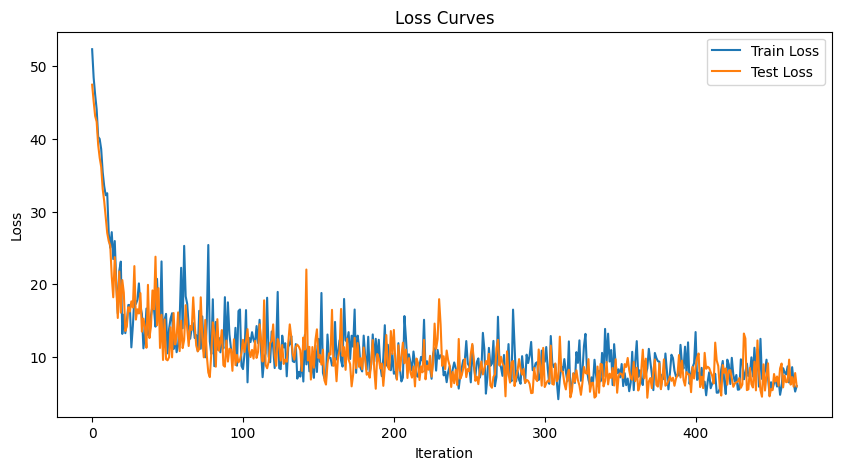

In [20]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [21]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9390/10000
Test Set Accuracy: 93.90%
